# Imports

In [1]:
# Python standard library
import sys
import csv

# Scientific computing
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage

# Program specific
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/rp/')
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/')
import resistive_pulse as rp
import rp_file
import optical_imaging as oi
import oi_file


# Jupyter
from IPython.display import HTML

# Load data

In [2]:
date = '7-17-2017/'
particle = '293-T/'
channel = '15-30-15_6/'
file_index = '0'

base_path = '/home/prestonh/Desktop/Research/cancer_cells/data/'

oi_vid_file_path = base_path + date + particle + channel + 'oi/bin/test_camera_' + file_index
oi_events_file_path = base_path + date + particle + channel + 'oi/events/test_camera_' + file_index + '_events.json'

In [3]:
# Load video
oi_vid = oi_file.Video(oi_vid_file_path, 512, 288, 100000)

# Load events
oi_events = oi_file.open_event_file_json(oi_events_file_path)

/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/optical_imaging.py:63: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pixels != None:


##### Load ellipses

In [7]:
oi_ellipse_base_path = '../data/'
oi_ellipse_path = oi_ellipse_base_path + date + particle + channel + 'ellipses_' + file_index

ellipsess = []


with open(oi_ellipse_path, 'r') as file_handle:
    file_reader = csv.reader(file_handle, delimiter = '\t')
    
    # Skip header
    header_length = 2
    for i in range(header_length):
        next(file_reader)
        
        
    for row in file_reader:
        
        if row[0] == 'event #':
            # New event
            ellipsess.append([])
            continue
            
        else:
            ellipse = []
            for ele in row:
                try:
                    ellipse.append(float(ele))
                except:
                    ellipse.append(0)
                    
            ellipsess[-1].append(ellipse)

# Load template and create stage

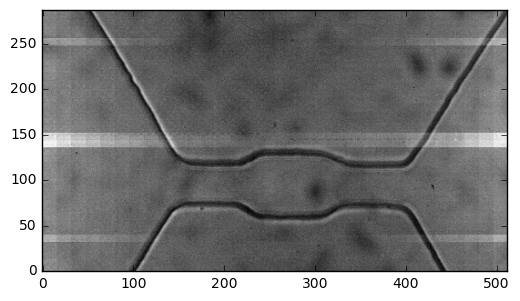

In [10]:
template_index = 1600

template_frame = oi_vid.get_frame(template_index)

plt.imshow(template_frame, cmap = 'gray', origin = 'lower')
plt.show()

[ 0.01224398  0.99992504]


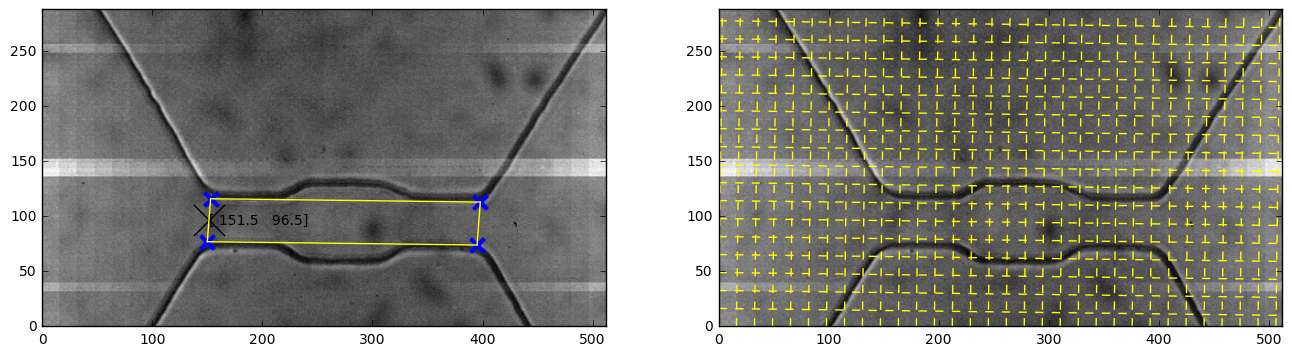

In [11]:
reload(oi)
template_frame = oi_vid.get_frame(template_index)
c0 = [153,116]
c1 = [150,77]
c2 = [395,74]
c3 = [398,113]
oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
oi_stage.plot_stage()

# Begin filtering

In [7]:
filtering_steps = {}

## Geometry based filtering

### Get initial frame

/home/prestonh/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in double_scalars


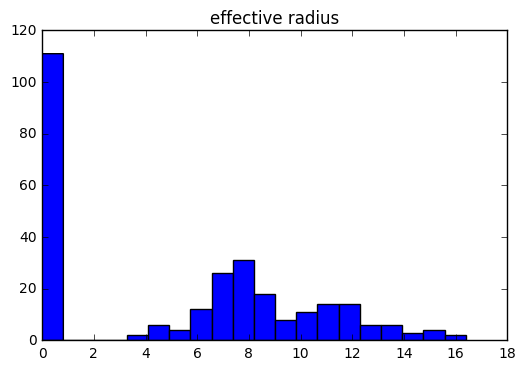

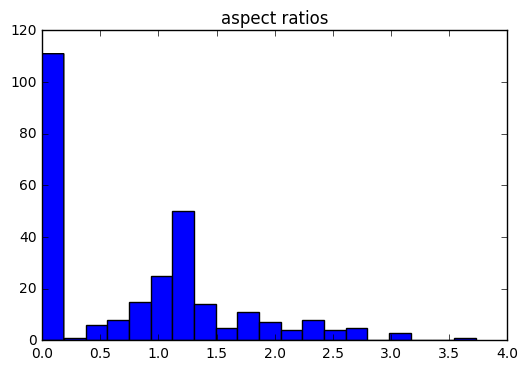

In [10]:
xc_left = -30
xc_right = -10



aspect_ratios = []
effective_radii = []

for i, oi_event in enumerate(oi_events):
  
    aspect_ratio = 0
    effective_radius = 0
    for j, ellipse in enumerate(ellipsess[i]):
        
        x = ellipse[1]
        y = ellipse[2]
        
        xc, yc = oi_stage.get_channel_coordinates(x, y)
        xc = oi_stage.pixels_to_meters(xc)
        
        
        
        
        if xc > xc_left and xc < xc_right:
            
            ax0 = ellipse[3]
            ax1 = ellipse[4]
            
            a = oi_stage.pixels_to_meters(ax0)
            b = oi_stage.pixels_to_meters(ax1)
            
            aspect_ratio = a/b

            effective_radius = np.sqrt(a*b)
        
            break
            
    if np.isnan(aspect_ratio) or np.isinf(aspect_ratio):
        aspect_ratio = 0
    if np.isnan(effective_radius) or np.isinf(aspect_ratio):
        effective_radius = 0
            
    aspect_ratios.append(aspect_ratio)
    effective_radii.append(effective_radius)
            
            
plt.hist(effective_radii, bins = 20)
plt.title('effective radius')
plt.show()
            
plt.hist(aspect_ratios, bins = 20)
plt.title('aspect ratios')
plt.show()      

## Filter size

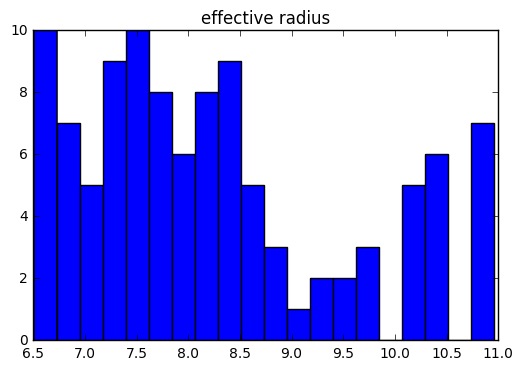

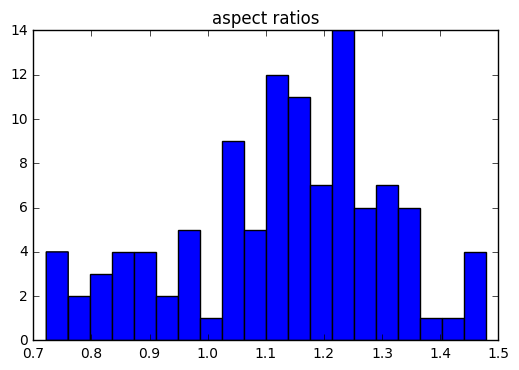

radius filtering 172/278

aspect ratio filtering 170/278

events filtered by radius:
[0, 1, 2, 3, 4, 6, 7, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 36, 38, 39, 40, 41, 42, 43, 44, 47, 49, 51, 52, 57, 59, 61, 63, 67, 69, 71, 72, 73, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 93, 94, 96, 98, 100, 102, 107, 108, 109, 110, 111, 112, 113, 114, 116, 118, 119, 120, 121, 123, 127, 128, 129, 130, 133, 134, 135, 138, 144, 145, 146, 147, 148, 149, 151, 152, 153, 156, 158, 159, 161, 164, 165, 168, 169, 170, 171, 174, 177, 180, 181, 184, 187, 188, 189, 191, 192, 195, 196, 199, 200, 201, 202, 203, 204, 206, 207, 211, 212, 213, 215, 216, 218, 220, 221, 222, 223, 224, 226, 227, 228, 229, 231, 233, 234, 236, 238, 239, 240, 242, 244, 245, 247, 248, 249, 250, 254, 255, 256, 257, 258, 263, 266, 267, 269, 270, 271, 272, 273, 275, 276, 277]

events filtered by aspect:
[1, 2, 3, 7, 11, 13, 14, 15, 17, 19, 21, 22, 24, 25, 28, 31, 32, 36, 37, 38, 39, 40, 42, 43, 44, 

In [11]:
# Filter size
radius_min = 6.5
radius_max = 11

filtering_steps['effective radius'] = [radius_min, radius_max]

keep_indices_radius = [i for i in range(len(effective_radii)) if ((effective_radii[i] > radius_min) and (effective_radii[i] < radius_max))]


# Filter aspect

aspect_min = 0.7 
aspect_max = 1.5

filtering_steps['aspect ratio'] = [aspect_min, aspect_max]

keep_indices_aspect = [i for i in range(len(aspect_ratios)) if ((aspect_ratios[i] > aspect_min) and (aspect_ratios[i] < aspect_max))]



# Histograms
plt.hist(np.array(effective_radii)[keep_indices_radius], bins = 20)
plt.title('effective radius')
plt.show()
            
plt.hist(np.array(aspect_ratios)[keep_indices_aspect], bins = 20)
plt.title('aspect ratios')
plt.show()  




# Print

print ('radius filtering ' + str(len(oi_events) - len(keep_indices_radius)) + '/' + str(len(oi_events)))

print


print ('aspect ratio filtering ' + str(len(oi_events) - len(keep_indices_aspect)) + '/' + str(len(oi_events)))

print


print ('events filtered by radius:')
print([i for i in range(len(oi_events)) if i not in keep_indices_radius])

print

print ('events filtered by aspect:')
print([i for i in range(len(oi_events)) if i not in keep_indices_aspect])

print

print('events filtered out by size but kept by aspect:')
print([i for i in range(len(oi_events)) if (i in keep_indices_aspect) and (i not in keep_indices_radius)])

print


print('events filtered out by aspect but kept by size:')
print([i for i in range(len(oi_events)) if (i not in keep_indices_aspect) and (i in keep_indices_radius)])

print


    


In [13]:
oi_index = 84
print effective_radii[oi_index]
reload(oi_file)
plt.close()
HTML(oi_file.make_animation(oi_vid, oi_events[oi_index]._detections[0]._tf, oi_events[oi_index]._detections[-1]._tf).to_html5_video())

13.32212907


### Filter aspect ratio

In [14]:
aspect_min = 0.7 
aspect_max = 1.5

filtering_steps['aspect ratio'] = [aspect_min, aspect_max]

keep_indices_aspect = [i for i in range(len(aspect_ratios)) if ((aspect_ratios[i] > aspect_min) and (aspect_ratios[i] < aspect_max))]

print ('aspect ratio filtering ' + str(len(oi_events) - len(keep_indices_aspect)) + '/' + str(len(oi_events)))

print

print ('events filtered by aspect:')
print([i for i in range(len(oi_events)) if i not in keep_indices_aspect])

print

print('events filtered out by size but kept by aspect:')
print([i for i in range(len(oi_events)) if (i in keep_indices_aspect) and (i not in keep_indices_radius)])

print


print('events filtered out by aspect but kept by size:')
print([i for i in range(len(oi_events)) if (i not in keep_indices_aspect) and (i in keep_indices_radius)])

print



aspect ratio filtering 170/278

events filtered by aspect:
[1, 2, 3, 7, 11, 13, 14, 15, 17, 19, 21, 22, 24, 25, 28, 31, 32, 36, 37, 38, 39, 40, 42, 43, 44, 46, 47, 49, 51, 52, 53, 55, 58, 59, 60, 61, 66, 68, 69, 71, 72, 73, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 88, 90, 91, 93, 94, 95, 98, 99, 100, 105, 109, 110, 111, 112, 113, 114, 116, 118, 119, 120, 121, 122, 127, 129, 130, 133, 134, 135, 138, 139, 144, 147, 148, 149, 151, 152, 153, 154, 156, 158, 159, 161, 164, 165, 166, 167, 168, 170, 171, 173, 175, 177, 180, 181, 183, 187, 188, 189, 190, 191, 195, 196, 199, 201, 202, 203, 204, 206, 207, 211, 212, 213, 215, 216, 217, 218, 221, 222, 223, 224, 226, 227, 228, 229, 230, 232, 233, 234, 235, 236, 239, 241, 242, 244, 245, 247, 248, 249, 250, 252, 254, 255, 256, 257, 258, 259, 260, 261, 263, 266, 267, 269, 270, 272, 273, 275, 276, 277]

events filtered out by size but kept by aspect:
[0, 4, 6, 16, 20, 23, 27, 41, 57, 63, 67, 81, 84, 87, 89, 96, 102, 107, 108, 123, 128, 145, 146, 169, 174

In [15]:
oi_index = 58
print 'effective radius:', effective_radii[oi_index]
print 'aspect:', aspect_ratios[oi_index]
reload(oi_file)
plt.close()
HTML(oi_file.make_animation(oi_vid, oi_events[oi_index]._detections[0]._tf, oi_events[oi_index]._detections[-1]._tf).to_html5_video())

effective radius: 10.2364965598
aspect: 1.64859240972


### y-based filtering

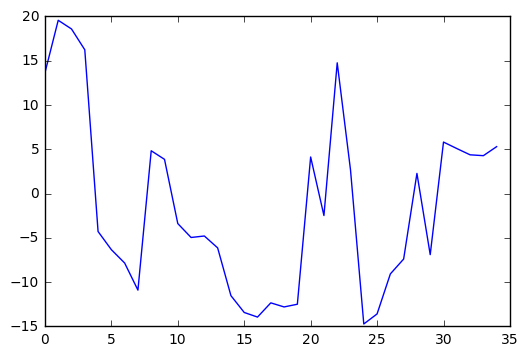

ValueError: zero-size array to reduction operation maximum which has no identity

In [24]:
# Central cavity y-based filtering

yc_middles = []

for i, oi_event in enumerate(oi_events):
    
    try:
        xs = [ellipse[1] for ellipse in ellipsess[i]]
        ys = [ellipse[2] for ellipse in ellipsess[i]]
    
    
        xcs, ycs = oi_stage.get_channel_coordinates(xs, ys)
        xcs = oi_stage.pixels_to_meters(xcs)
        ycs = oi_stage.pixels_to_meters(ycs)
        
        plt.plot(range(len(xcs)), ycs)
        plt.show()
        break
    
    
    
        is_interp = scipy.interpolate.interp1d(xcs, range(len(xcs)))
    
    
        i_middle = int(is_interp(oi_stage._length_microns/2.))
    
    
        yc_middles.append(ycs[i_middle])
        
    except:
        print 'failed', i
        yc_middles.append(10)
    
    
    
    
# Apply offset to y so centered at 0
offset = -(np.max(yc_middles) - np.abs(np.min(yc_middles)))/2.
yc_middles = np.array(yc_middles)
yc_middles = yc_middles + offset


# Plot hist of all ys
plt.hist(yc_middles, bins = 20)
plt.xlabel('yc')
plt.show()



In [ ]:
yc_threshold = 5
filtering_steps['yc cavity threshold'] = [yc_threshold]

keep_indices_y = np.where(np.abs(yc_middles) <= yc_threshold)[0]

print 'length before', len(oi_events), 'length after', len(keep_indices_y)
print
print keep_indices_y




In [ ]:
oi_index = 1
print yc_middles[oi_index]
reload(oi_file)
plt.close()
HTML(oi_file.make_animation(oi_vid, oi_events[oi_index]._detections[0]._tf, oi_events[oi_index]._detections[-1]._tf).to_html5_video())

## Manual filtering

In [ ]:
keep_indices = [i for i in range(len(oi_events)) if ((i in keep_indices_radius)\
                                                     and (i in keep_indices_aspect)\
                                                     and (i in keep_indices_y))]

print keep_indices

In [ ]:
oi_index = 4

reload(oi_file)
plt.close()
HTML(oi_file.make_animation(oi_vid, oi_events[oi_index]._detections[0]._tf, oi_events[oi_index]._detections[-1]._tf).to_html5_video())

In [ ]:
manual_remove_indices = []

filtering_steps['manual removal'] = [len(manual_remove_indices)]

keep_indices_manual = [i for i in range(len(oi_events)) if i not in manual_remove_indices]

## Filtering step

In [ ]:
keep_indices = [i for i in range(len(oi_events)) if ((i in keep_indices_radius)\
                                                     and (i in keep_indices_aspect)\
                                                     and (i in keep_indices_y)\
                                                    and (i in keep_indices_manual))]


print(keep_indices)
print('filtering ' + str(len(oi_events) - len(keep_indices)) + ' out of ' + str(len(oi_events)) + ' events')

# Save

### Save filtering parameters

output_file_path = '../data/' + date + particle + channel + 'filter_' + file_index
print output_file_path


with open(output_file_path, 'w') as file_handle:
    file_writer = csv.writer(file_handle, delimiter = '\t')
    
    
    # Write filtering steps
    for filtering_step in filtering_steps:
        file_writer.writerow(['filter step', filtering_step, filtering_steps[filtering_step]])
        
    file_writer.writerow(keep_indices)

### Save filtered events

oi_events_output_file_path = oi_events_file_path.replace('.json', '_filtered.json')
oi_file.save_oi_events_json(oi_events_output_file_path, oi_events_filtered)

### Save ellipsess

In [ ]:
def save_ellipes_frame(frame, ellipse):
    
    frame = np.copy(frame)[ellipse[1] - 30:ellipse[1] + 31, ellipse[2] - 30:ellipse[2] + 31]
    ellipse_axes_lengths = [ellipse[3], ellipse[4]]
    ellipse_angle = ellipse[5]
    
    
    # Create perimeter line
    ellipse_points = np.empty((100,2))
    for i in range(100):
        angle = i*2*np.pi/99.
        x = ellipse_axes_lengths[0]*np.cos(angle)
        y = ellipse_axes_lengths[1]*np.sin(angle)
        ellipse_points[i,0] = ellipse_center[0] + np.cos(ellipse_angle)*x + np.sin(ellipse_angle)*y
        ellipse_points[i,1] = ellipse_center[1] + np.sin(ellipse_angle)*x - np.cos(ellipse_angle)*y

  

    # Begin plot
    fig, axes = plt.subplots(1,2,figsize = (12,3))


    # Axes 0
    plt.sca(axes[0])
    plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
    plt.xlim(0, processed_frame.shape[1])
    plt.ylim(0, processed_frame.shape[0])


    # Axes 1
    plt.sca(axes[1])

    plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
    #plt.imshow(processed_frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
    plt.imshow(green_processed_frame, alpha = .15, origin = 'lower', interpolation = 'none')
    plt.plot(ellipse_points[:,0], ellipse_points[:,1], lw = 3, c = 'red')

    plt.scatter(ellipse_center[0], ellipse_center[1], marker = 'x', c = 'red', lw = 3, s = 20)


    ellipse_axis_a = [ellipse_axes_lengths[0]*np.cos(ellipse_angle), ellipse_axes_lengths[0]*np.sin(ellipse_angle)]
    ellipse_axis_b = [ellipse_axes_lengths[1]*np.sin(ellipse_angle), -ellipse_axes_lengths[1]*np.cos(ellipse_angle)]


    ax0 = ellipse_center[0]
    ax1 = ax0 + ellipse_axis_a[0]
    ay0 = ellipse_center[1]
    ay1 = ay0 + ellipse_axis_a[1]

    bx0 = ellipse_center[0]
    bx1 = bx0 + ellipse_axis_b[0]
    by0 = ellipse_center[1]
    by1 = by0 + ellipse_axis_b[1]

    plt.plot([ax0, ax1], [ay0, ay1], lw = 3, c = 'red')
    plt.plot([bx0, bx1], [by0, by1], lw = 3, c = 'red')

    plt.text((ax0+ax1)/2., (ay0+ay1)/2., 'a', color = 'red', size = 20, ha = 'left', va = 'bottom')
    plt.text((bx0+bx1)/2., (by0+by1)/2., 'b', color = 'red', size = 20, ha = 'left', va = 'bottom')

    plt.text(1, 0.2, r'$|a|=$'+str(round(ellipse_axes_lengths[0],3)), transform=plt.gca().transAxes, ha = 'right', va = 'bottom', size = 12, color = 'red')
    plt.text(1, 0.1, r'$|b|=$'+str(round(ellipse_axes_lengths[1],3)), transform=plt.gca().transAxes, ha = 'right', va = 'bottom', size = 12, color = 'red')

    plt.text(1, 0, r'$\theta=$'+str(round(ellipse_angle*180./np.pi,3)), transform=plt.gca().transAxes, ha = 'right', va = 'bottom', size = 12, color = 'red')



    plt.xlim(0, frame.shape[1])
    plt.ylim(0, frame.shape[0])

    plt.grid()

    plt.show()

In [ ]:
# Loop over events
for i, oi_event in enumerate(oi_events):
    
    # Check if this is actually an event we're saving
    if i in keep_indices:
        
        
        
        xcs = []
        
        # Loop over some detections
        for ellipse in ellipsess[i]:
            x = ellipse[1]
            y = ellipse[2]
            
            
            
            
        save_positions = [-25, 25, 75, 125, 175]
        
        
        # Loop over all the save positions
        for save_position in save_positions:
            for ellipse in ellipsess[i]:
                x = ellipse[1]
                y = ellipse[2]
                
                xc, yc = oi_stage.get_channel_coordinates(x, y)
                xc = oi_stage.pixels_to_meters(xc)
            
                if xc >= save_position:
                    oi_frame = oi_vid.get_frame(oi_event._detections[ellipse[0]])
                    
                    save_ellipse_frame(oi_event, oi_frame, ellipse)
                    
                    
                    
            
            
            
            
            
            
        
            
            
            
            
            
            
            print detection
        
        
        
        
        
        
    